In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('GOOGL.csv')

In [3]:
data_copy = data.copy()

data_copy.dropna(inplace=True)

selected_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data_copy = data_copy[selected_features]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_copy)

In [4]:
df = pd.DataFrame(data)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [24]:
df.iloc[3496]


Date         2018-07-10 00:00:00+00:00
Open                        1169.98999
High                            1173.5
Low                        1162.560059
Close                      1167.140015
Adj Close                  1167.140015
Volume                         1066700
Name: 3496, dtype: object

(4431, 7)

In [5]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns)
print("Info:\n", df.info())
print("Summary statistics:\n", df.describe())

Dataset shape: (4431, 7)
Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4431 entries, 0 to 4430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4431 non-null   object 
 1   Open       4431 non-null   float64
 2   High       4431 non-null   float64
 3   Low        4431 non-null   float64
 4   Close      4431 non-null   float64
 5   Adj Close  4431 non-null   float64
 6   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 242.4+ KB
Info:
 None
Summary statistics:
               Open         High          Low        Close    Adj Close   
count  4431.000000  4431.000000  4431.000000  4431.000000  4431.000000  \
mean    693.087345   699.735595   686.078751   693.097367   693.097367   
std     645.118799   651.331215   638.579488   645.187806   645.187806   
min      49.644646  

In [8]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19 00:00:00+00:00,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20 00:00:00+00:00,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23 00:00:00+00:00,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24 00:00:00+00:00,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25 00:00:00+00:00,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [20]:
df.shape

(4431, 7)

In [9]:
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 60  

X, y = prepare_data(scaled_data, time_steps)

In [22]:
len(y)

4371

In [10]:
split_ratio = 0.8  # Train-test split ratio
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [38]:
df.iloc[3496]

Date         2018-07-10 00:00:00+00:00
Open                        1169.98999
High                            1173.5
Low                        1162.560059
Close                      1167.140015
Adj Close                  1167.140015
Volume                         1066700
Name: 3496, dtype: object

In [11]:
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=100, return_sequences=True),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=len(selected_features))
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

# Display model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           42800     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 6

In [12]:
epochs = 20 

history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

Epoch 1/20
110/110 [==============================] - 46s 263ms/step - loss: 0.0018 - accuracy: 0.4514
Epoch 2/20
110/110 [==============================] - 24s 216ms/step - loss: 9.9530e-04 - accuracy: 0.4477
Epoch 3/20
110/110 [==============================] - 26s 236ms/step - loss: 8.9745e-04 - accuracy: 0.4582
Epoch 4/20
110/110 [==============================] - 25s 232ms/step - loss: 8.4214e-04 - accuracy: 0.4577
Epoch 5/20
110/110 [==============================] - 23s 212ms/step - loss: 8.0182e-04 - accuracy: 0.4611
Epoch 6/20
110/110 [==============================] - 24s 222ms/step - loss: 7.7666e-04 - accuracy: 0.4780
Epoch 7/20
110/110 [==============================] - 23s 208ms/step - loss: 7.3937e-04 - accuracy: 0.4720
Epoch 8/20
110/110 [==============================] - 24s 218ms/step - loss: 7.5578e-04 - accuracy: 0.4700
Epoch 9/20
110/110 [==============================] - 25s 228ms/step - loss: 7.3550e-04 - accuracy: 0.4765
Epoch 10/20
110/110 [====================

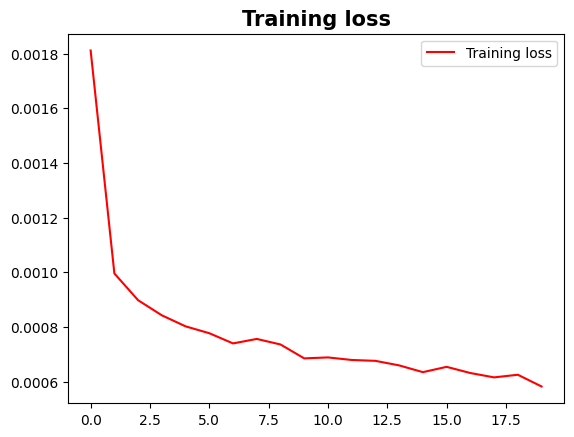

<Figure size 640x480 with 0 Axes>

Train Loss: [0.0004765246412716806, 0.584382176399231]
Test Loss: [0.0012832677457481623, 0.2297142893075943]


In [13]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')

plt.title('Training loss', size=15, weight='bold')
plt.legend(loc=0)
plt.figure()

plt.show()

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}")
print(f"Test Loss: {test_loss}")

In [40]:
split_index=3496
df.iloc[3496]

Date         2018-07-10 00:00:00+00:00
Open                        1169.98999
High                            1173.5
Low                        1162.560059
Close                      1167.140015
Adj Close                  1167.140015
Volume                         1066700
Name: 3496, dtype: object

28/28 [==============================] - 2s 74ms/step


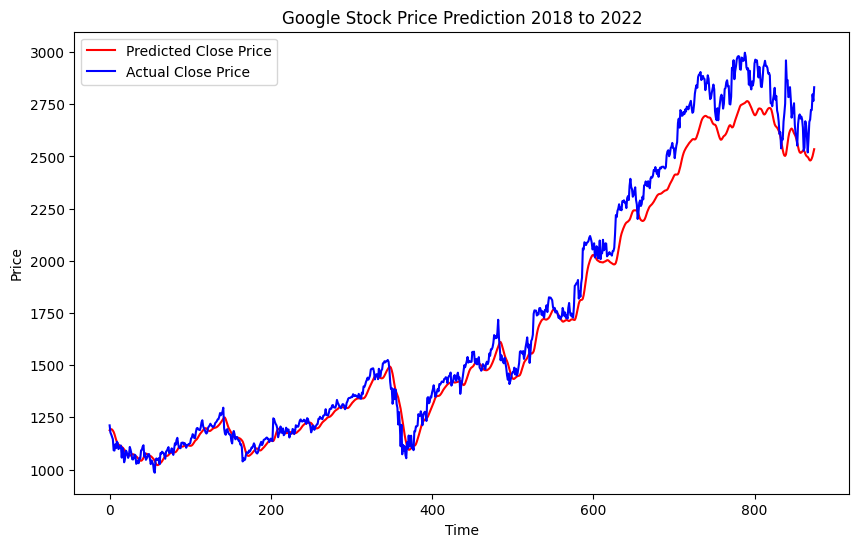

In [42]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 6))
plt.plot(predictions[:,4], label='Predicted Close Price', color='r')
plt.plot(y_test_inverse[:,4], label='Actual Close Price', color='b')
plt.title('Google Stock Price Prediction 2018 to 2022')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming predictions and y_test_inverse contain the predicted and actual stock prices, respectively

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverse[:,4],predictions[:,4])

print(f'Mean Absolute Error (MAE): {mae}')



Mean Absolute Error (MAE): 72.4437768478884
